In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Week 1 work
start_date = '1990-01-01'
end_date = '1999-12-31'
sp500_data = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')
sp500_data.columns = sp500_data.columns.get_level_values(0)
sp500_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
1990-01-01,329.079987,360.589996,319.829987,353.399994,3793250000
1990-02-01,331.890015,336.089996,322.100006,329.079987,2961970000
1990-03-01,339.940002,344.489990,331.079987,331.890015,3283280000
1990-04-01,330.799988,347.299988,327.760010,339.940002,2801220000
1990-05-01,361.230011,362.260010,330.799988,330.799988,3596680000


In [5]:
sp500_data = sp500_data[['Close']].dropna()

sp500_data['Log Return'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))

sp500_data.dropna(inplace=True)

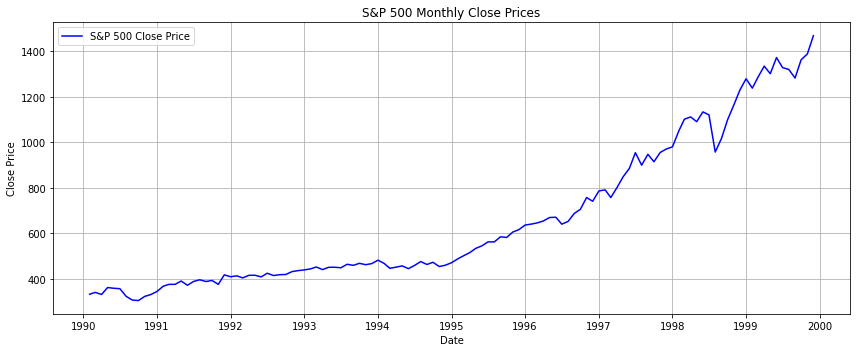

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(sp500_data.index, sp500_data['Close'], label='S&P 500 Close Price', color='blue')
plt.title('S&P 500 Monthly Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

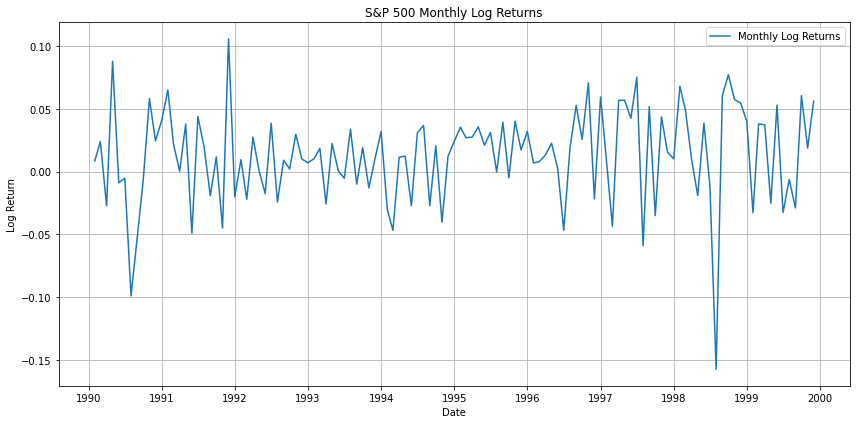

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns')
plt.title('S&P 500 Monthly Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

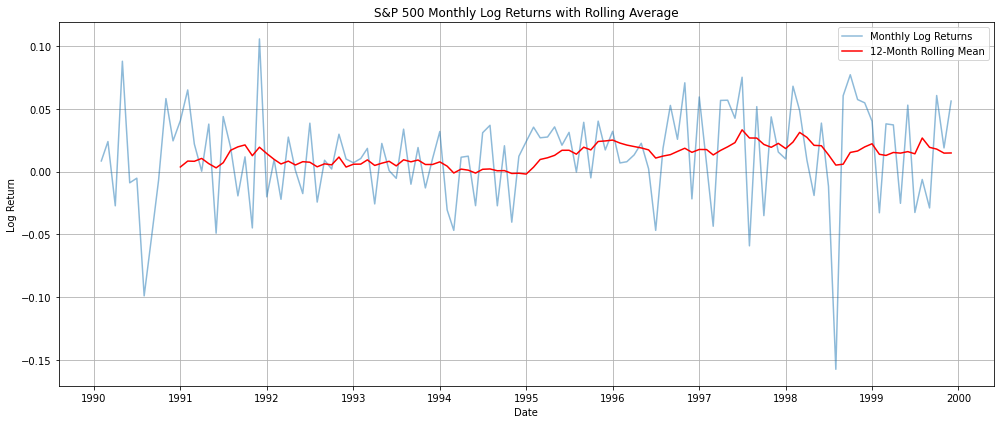

In [8]:
sp500_data['Rolling Mean'] = sp500_data['Log Return'].rolling(window=12).mean() 
#first 11 values are meant to be empty for rolling mean, don't get scared!
plt.figure(figsize=(14, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns', alpha=0.5)
plt.plot(sp500_data.index, sp500_data['Rolling Mean'], label='12-Month Rolling Mean', color='red')
plt.title('S&P 500 Monthly Log Returns with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

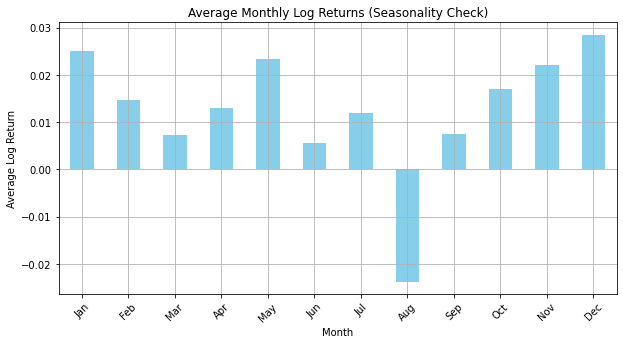

In [9]:
sp500_data['Month'] = sp500_data.index.month
monthly_avg = sp500_data.groupby('Month')['Log Return'].mean()

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Log Returns (Seasonality Check)')
plt.xlabel('Month')
plt.ylabel('Average Log Return')
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
#plt.tight_layout()
plt.show()


<Figure size 864x432 with 0 Axes>

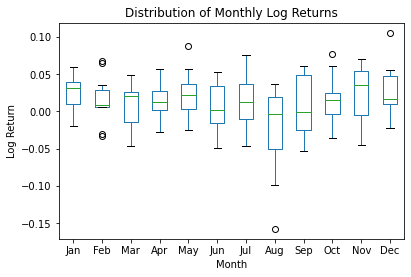

In [10]:
plt.figure(figsize=(12, 6))
sp500_data.boxplot(column='Log Return', by='Month', grid=False)
plt.title('Distribution of Monthly Log Returns')
plt.suptitle('')  # Hide default title
plt.xlabel('Month')
plt.ylabel('Log Return')
plt.xticks(ticks=range(1,13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#plt.tight_layout()
plt.show()

In [11]:
# Week 2 work 

# ADF test on log returns

adf_result = adfuller(sp500_data['Log Return'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -11.933121
p-value: 0.000000
Critical Values:
	1%: -3.4870216863700767
	5%: -2.8863625166643136
	10%: -2.580009026141913


**Analysis:**

The ADF test statistic of -11.933 and the p-value of 0.000 both indicate that the null hypothesis of a unit root can be rejected with strong confidence. This supports the conclusion that the time series is stationary, meaning it does not show a trend or non-stationary behavior.

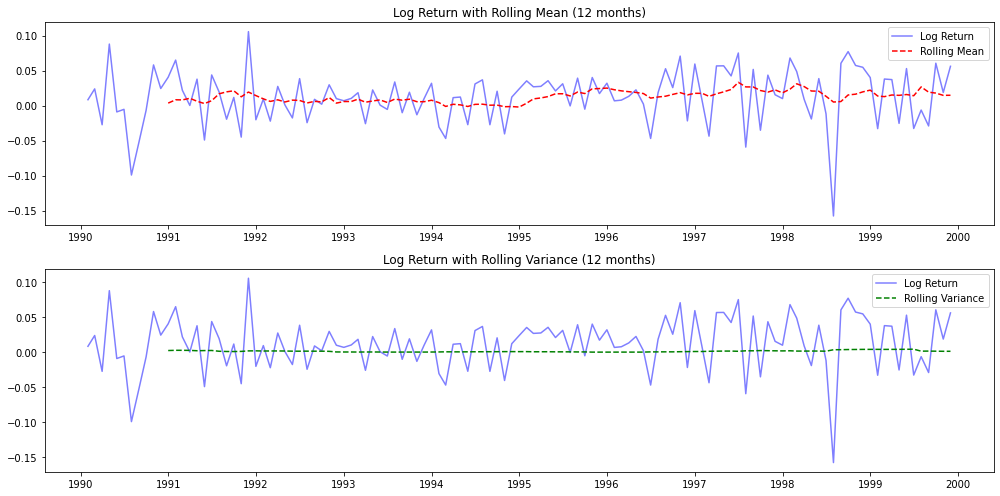

In [12]:
# rolling mean and rolling variance

window = 12

rolling_mean = sp500_data['Log Return'].rolling(window=window).mean()
rolling_variance = sp500_data['Log Return'].rolling(window=window).var()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.title('Log Return with Rolling Mean (12 months)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_variance, label='Rolling Variance', color='green', linestyle='--')
plt.title('Log Return with Rolling Variance (12 months)')
plt.legend()

plt.tight_layout()
plt.show()

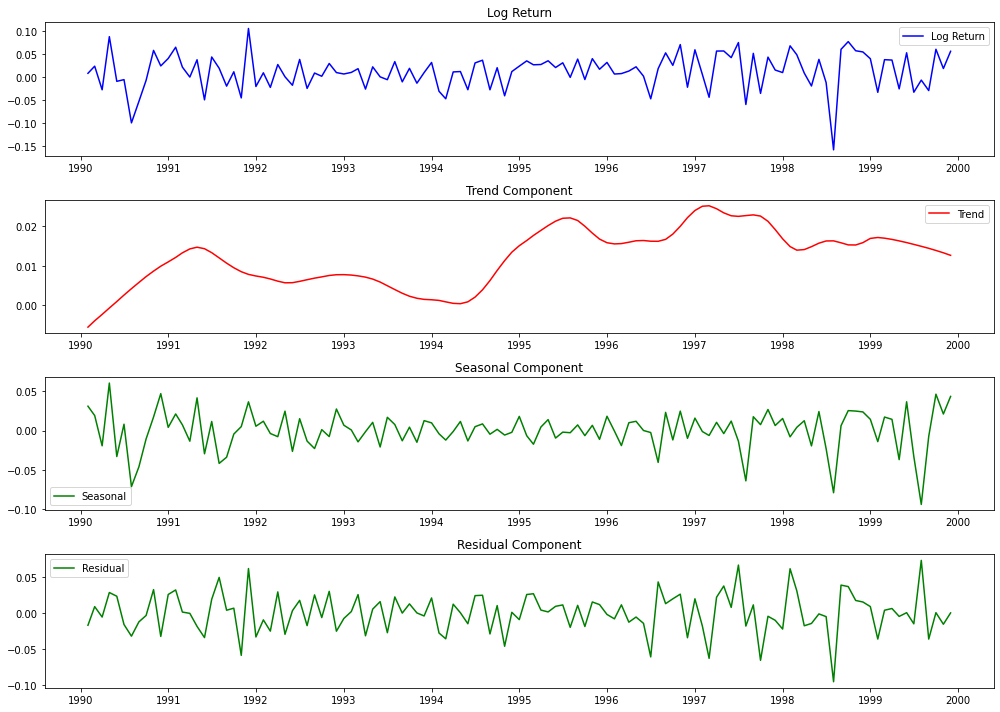

In [13]:
# perform STL decomposition on the log returns

stl = STL(sp500_data['Log Return'], period=12)
result = stl.fit()

seasonal = result.seasonal
trend = result.trend
residual = result.resid

plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue')
plt.title('Log Return')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(sp500_data.index, trend, label='Trend', color='red')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sp500_data.index, seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sp500_data.index, residual, label='Residual', color='green')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
arima_model = ARIMA(sp500_data['Log Return'], order=(1, 0, 1))
arima_result = arima_model.fit()
print("ARIMA Model Summary:")
print(arima_result.summary())

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             Log Return   No. Observations:                  119
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 220.941
Date:                Sun, 27 Apr 2025   AIC                           -433.881
Time:                        20:11:33   BIC                           -422.765
Sample:                    02-01-1990   HQIC                          -429.367
                         - 12-01-1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0125      0.004      3.536      0.000       0.006       0.020
ar.L1         -0.4566      0.625     -0.730      0.465      -1.682       0.769
ma.L1          0.3514      0.65

**Analysis:**

The ARIMA(1, 0, 1) model results show the following:

* **Constant (const):** The coefficient is 0.0125, and it's statistically significant (p-value = 0.000), indicating a positive drift in the time series, meaning the average return tends to increase over time.

* **AR(1) coefficient:** The coefficient is -0.4566, but the p-value is 0.465, which is not significant. This suggests that the first lag of the series does not strongly influence the current value.

* **MA(1) coefficient:** The coefficient is 0.3514, but the p-value is 0.594, which is also not significant, meaning the model's first moving average term doesn't capture significant patterns from past errors.

* **Sigma2:** The coefficient of 0.0014 is highly significant (p-value = 0.000), suggesting that the model's error variance is low and well-defined.

* **Ljung-Box (Q) test:** The p-value of 0.97 suggests that there are no significant autocorrelation issues left in the residuals at lag 1, meaning the model has accounted for most of the autocorrelation.

* **Jarque-Bera (JB) test:** The p-value of 0.00 indicates that the residuals are not normally distributed, with signs of skewness (-0.93) and kurtosis (5.95), meaning the residuals have heavy tails and are asymmetrical.

* **Heteroskedasticity (H):** A p-value of 0.12 suggests that there's no significant issue with varying volatility in the residuals.

In [17]:
sarima_model = SARIMAX(sp500_data['Log Return'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit()
print("\nSARIMA Model Summary:")
print(sarima_result.summary())


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.81944D+00    |proj g|=  7.96519D-01

At iterate    5    f= -1.82012D+00    |proj g|=  7.62788D-01

At iterate   10    f= -1.82250D+00    |proj g|=  1.60939D-02

At iterate   15    f= -1.82269D+00    |proj g|=  1.95378D-01

At iterate   20    f= -1.82618D+00    |proj g|=  1.39382D-01

At iterate   25    f= -1.82672D+00    |proj g|=  1.91070D-02

At iterate   30    f= -1.82673D+00    |proj g|=  2.66757D-03

At iterate   35    f= -1.82676D+00    |proj g|=  2.34704D-02

At iterate   40    f= -1.82770D+00    |proj g|=  9.52259D-02

At iterate   45    f= -1.82793D+00    |proj g|=  1.69163D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

**Analysis:**

The SARIMA(1, 0, 1)x(1, 0, 1, 12) model shows the following key results:

* **Seasonal AR (AR.S.L12):** 0.7848 (p-value = 0.004), which is statistically significant, indicating that the seasonal pattern at lag 12 (12-month period) has a positive impact on the current value, implying some repeating pattern in the data every 12 periods.

* **Seasonal MA (MA.S.L12):** -0.6015 (p-value = 0.062), which is marginally significant, indicating that past errors at the seasonal lag also have a slight negative effect on the current value.

* **Sigma² (error variance):** 0.0015 (p-value = 0.000), which is highly significant, suggesting low and well-defined error variance in the model.

* **Ljung-Box Q-test:** p-value of 0.66 indicates that there are no significant autocorrelation issues in the residuals, confirming that the model has accounted for temporal dependencies.

* **Jarque-Bera test:** p-value 0.00, showing that the residuals are not normally distributed, with skewness of -0.77 and kurtosis of 5.11, implying the residuals have heavy tails and are slightly negatively skewed.

In [18]:
# Ensure 'Month' column is category
sp500_data['Month'] = sp500_data.index.month.astype('category')

# Create dummy variables (January as baseline)
month_dummies = pd.get_dummies(sp500_data['Month'], drop_first=True)

# Regression setup
X = sm.add_constant(month_dummies)
y = sp500_data['Log Return']

reg_model = sm.OLS(y, X)
reg_result = reg_model.fit()

print("\nRegression Summary (Monthly Dummies):")
print(reg_result.summary())



Regression Summary (Monthly Dummies):
                            OLS Regression Results                            
Dep. Variable:             Log Return   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.311
Date:                Sun, 27 Apr 2025   Prob (F-statistic):              0.228
Time:                        20:20:15   Log-Likelihood:                 227.64
No. Observations:                 119   AIC:                            -431.3
Df Residuals:                     107   BIC:                            -397.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

**Analysis:**

The OLS regression results for monthly dummies show the following key findings:

* **Intercept (const):** 0.0250 (p-value = 0.049), statistically significant, meaning that the baseline month (January) has a positive log return, which is significant at the 5% level.

* **Other Months:** Most months (2–12) do not have statistically significant coefficients, indicating that there are no strong month-to-month variations in returns beyond January, with the exception of Month 8 (August) with a coefficient of -0.0488 (p-value = 0.006), which is statistically significant and indicates a negative log return in August compared to January.

* **Jarque-Bera test:** p-value = 0.111, suggesting that the residuals are approximately normally distributed (as the p-value is greater than 0.05).

* **Skew:** -0.406, indicating that the distribution of residuals is slightly negatively skewed.

* **Kurtosis:** 3.476, which is close to the normal distribution value of 3, suggesting that the residuals have near-normal kurtosis.

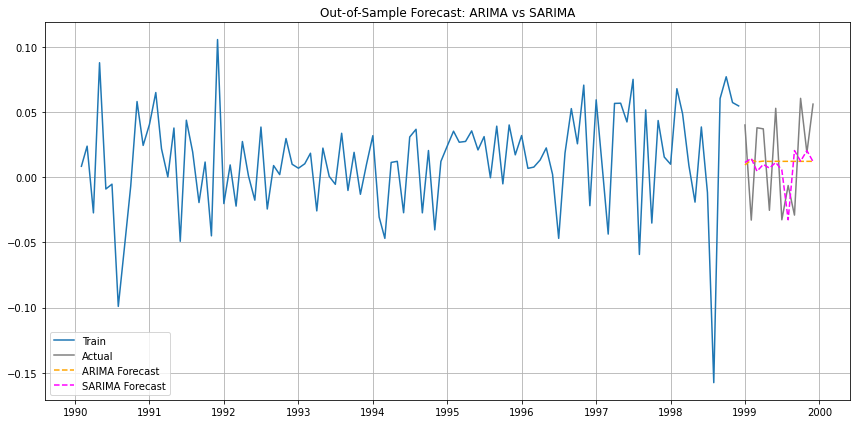

In [19]:
# week 4

# generate out of sample forecasts from ARIMA & SARIMA models

# split the data into testing and training 
train = sp500_data['Log Return'][:-12] 
test = sp500_data['Log Return'][-12:] # last 12 months

# fit ARIMA model w/ training data
arima_model = ARIMA(train, order=(1, 0, 1))
arima_result = arima_model.fit()

# forecast ARIMA
arima_forecast = arima_result.forecast(steps=12)

# fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit(disp=False)

# forecast SARIMA
sarima_forecast = sarima_result.forecast(steps=12)

# plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='grey')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--', color='magenta')
plt.title('Out-of-Sample Forecast: ARIMA vs SARIMA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

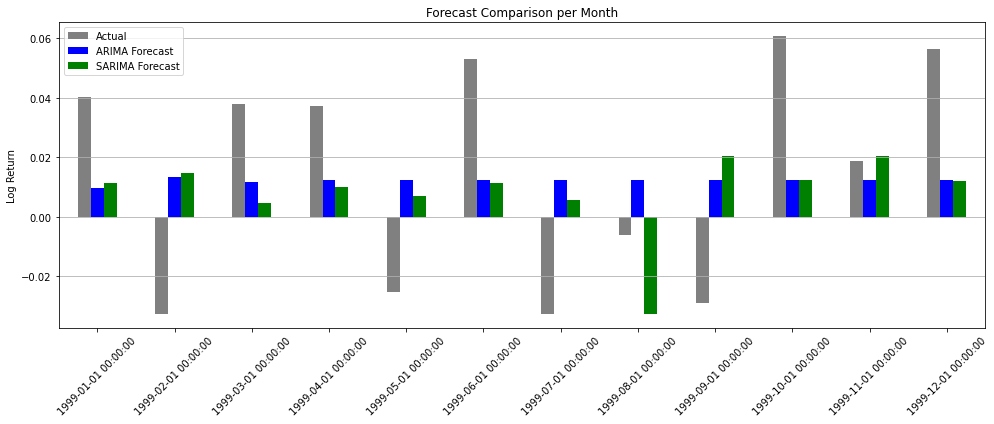

In [20]:
# plot monthly forecast comparisons

df_compare = pd.DataFrame({
    'Actual': test,
    'ARIMA Forecast': arima_forecast,
    'SARIMA Forecast': sarima_forecast
})

df_compare.plot(kind='bar', figsize=(14, 6), color=['grey', 'blue', 'green'])
plt.title('Forecast Comparison per Month')
plt.ylabel('Log Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

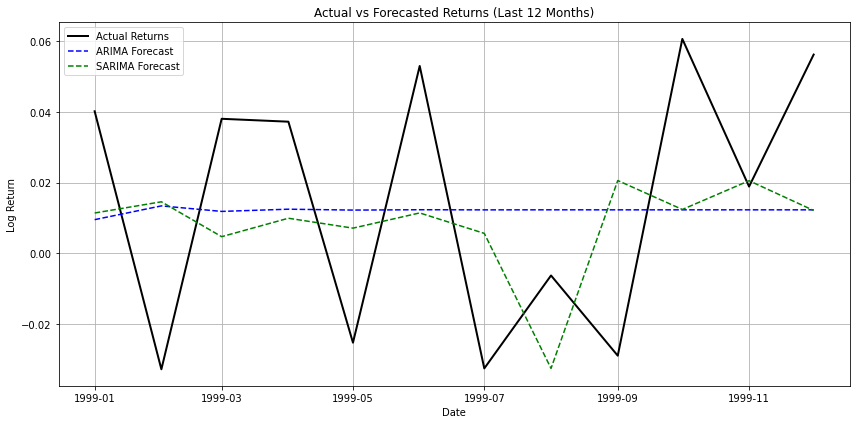

In [21]:
# actuals vs forecasted results plot

plt.figure(figsize=(12, 6))

# actual
plt.plot(test.index, test, label='Actual Returns', color='black', linewidth=2)

# ARIMA forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue', linestyle='--')

# SARIMA forecast
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')

plt.title('Actual vs Forecasted Returns (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# evaluate forcasting accuracy using MAE and RMSE

# ARIMA accuracy
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))

# SARIMA accuracy
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

print("Forecast Accuracy (last 12 months):")
print(f"ARIMA MAE: {arima_mae:.5f}")
print(f"ARIMA RMSE: {arima_rmse:.5f}")
print()
print(f"SARIMA MAE: {sarima_mae:.5f}")
print(f"SARIMA RMSE: {sarima_rmse:.5f}")

Forecast Accuracy (last 12 months):
ARIMA MAE: 0.03414
ARIMA RMSE: 0.03630

SARIMA MAE: 0.03491
SARIMA RMSE: 0.03719


**Analysis:**

ARIMA slightly outperforms SARIMA in forecast accuracy, with lower MAE (0.03414) and RMSE (0.03630) compared to SARIMA's MAE (0.03491) and RMSE (0.03719). Both models show similar error levels.

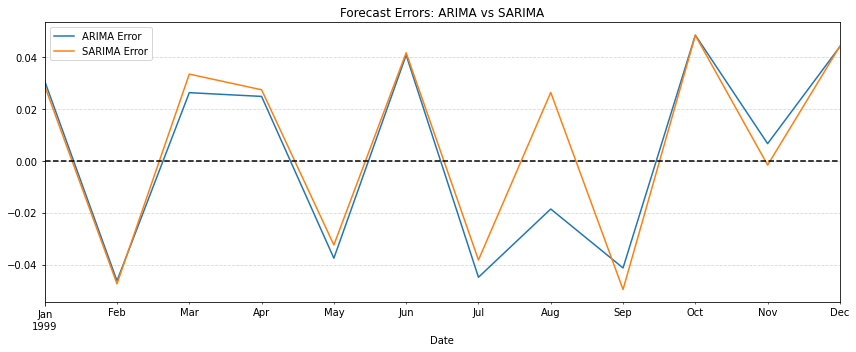

In [23]:
# plot forecast errors for ARIMA & SARIMA

errors = pd.DataFrame({
    'ARIMA Error': test - arima_forecast,
    'SARIMA Error': test - sarima_forecast
})

errors.plot(figsize=(12, 5), title='Forecast Errors: ARIMA vs SARIMA')
plt.axhline(0, color='black', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()